# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import helper_functions as hf
import matplotlib.pyplot as plt
import itertools
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
data_wide = pd.read_csv('./zillow_data.csv')

In [3]:
data_wide.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
data_long = hf.melt_data_v2(data_wide)
data_long['time'] = pd.to_datetime(data_long['time'], format='%Y-%m-%d')
data_long['RegionName'] = data_long['RegionName'].astype('str')

data_long.set_index(keys='time', inplace=True)
data_long.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0


In this project, we will be looing at zip codes in Florida, specifically areas near Orlando

In [5]:
#separate out areas within the state of Florida
df_fl = data_long.loc[data_long.State=='FL']
df_fl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205265 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      205265 non-null int64
RegionName    205265 non-null object
City          205265 non-null object
State         205265 non-null object
Metro         198110 non-null object
CountyName    205265 non-null object
SizeRank      205265 non-null int64
value         205265 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 14.1+ MB


In [6]:
df_fl.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         7155
CountyName       0
SizeRank         0
value            0
dtype: int64

In [7]:
df_fl.info()
df_fl.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205265 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID      205265 non-null int64
RegionName    205265 non-null object
City          205265 non-null object
State         205265 non-null object
Metro         198110 non-null object
CountyName    205265 non-null object
SizeRank      205265 non-null int64
value         205265 non-null float64
dtypes: float64(1), int64(2), object(5)
memory usage: 14.1+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0
1996-04-01,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0
1996-04-01,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0
1996-04-01,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0
1996-04-01,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0


# Step 2: Data Preprocessing

# Step 3: EDA and Visualization

In [8]:
from matplotlib import rc

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [9]:
# In the state array, there are 51 entries.
data_long.State.unique().shape

(51,)

In [12]:
df_fl.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,71831,32162,The Villages,FL,The Villages,Sumter,12,101000.0
1996-04-01,72463,33160,Sunny Isles Beach,FL,Miami-Fort Lauderdale,Miami-Dade,61,337300.0
1996-04-01,72363,33025,Miramar,FL,Miami-Fort Lauderdale,Broward,83,111600.0
1996-04-01,72578,33411,Royal Palm Beach,FL,Miami-Fort Lauderdale,Palm Beach,84,126800.0
1996-04-01,72442,33139,Miami Beach,FL,Miami-Fort Lauderdale,Miami-Dade,85,480200.0


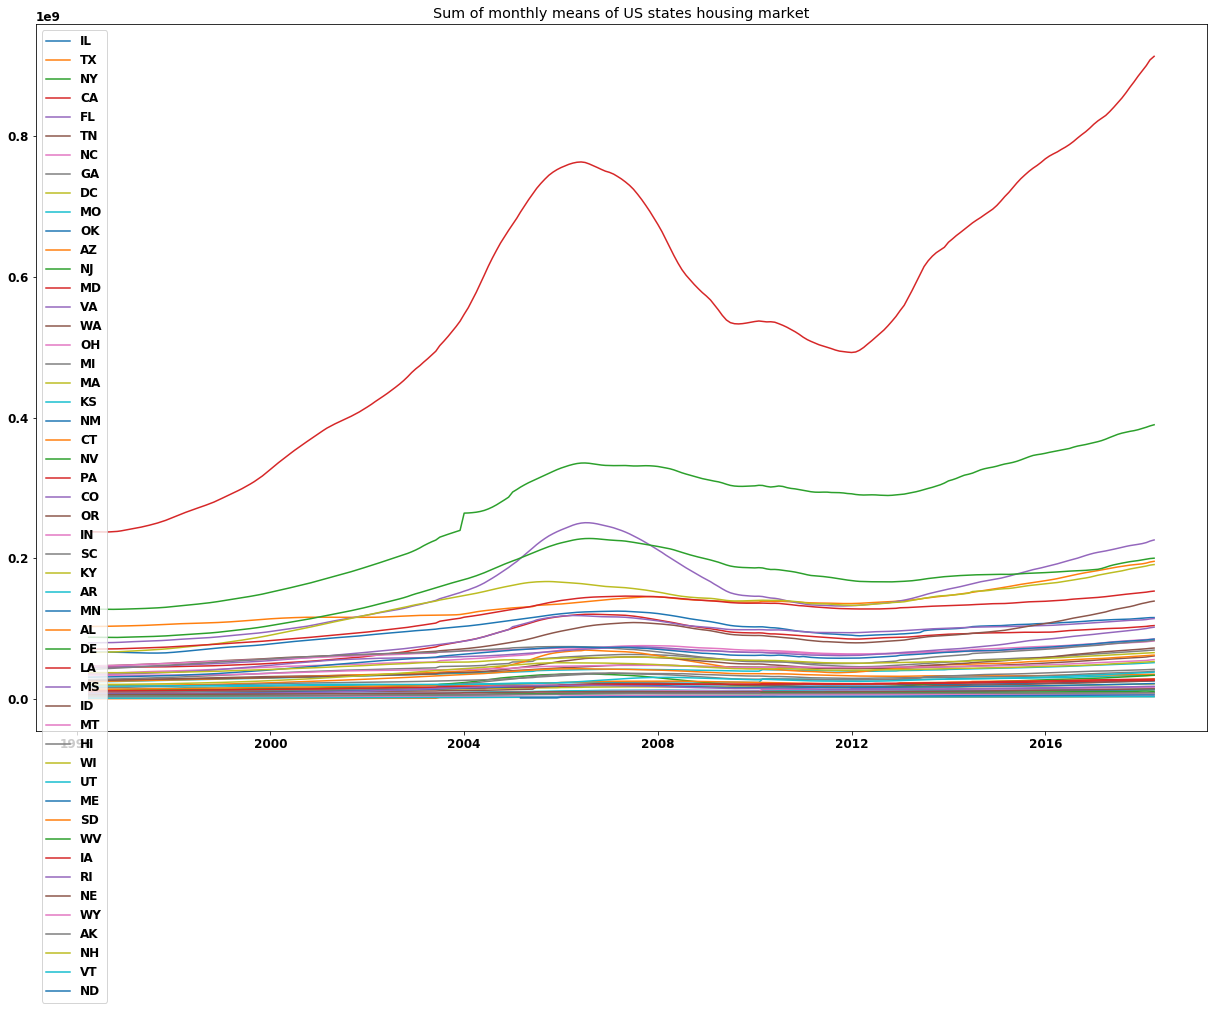

In [11]:
#Looking at each state to see the total means over the years
plt.figure(figsize=(21,13))
for state in data_long.State.unique():
    state_data = data_long.loc[(data_long.State==state), ['value']].resample('MS').sum()
    plt.plot(state_data, label=state)
    
plt.title('Sum of monthly means of US states housing market')
plt.legend()
plt.show()

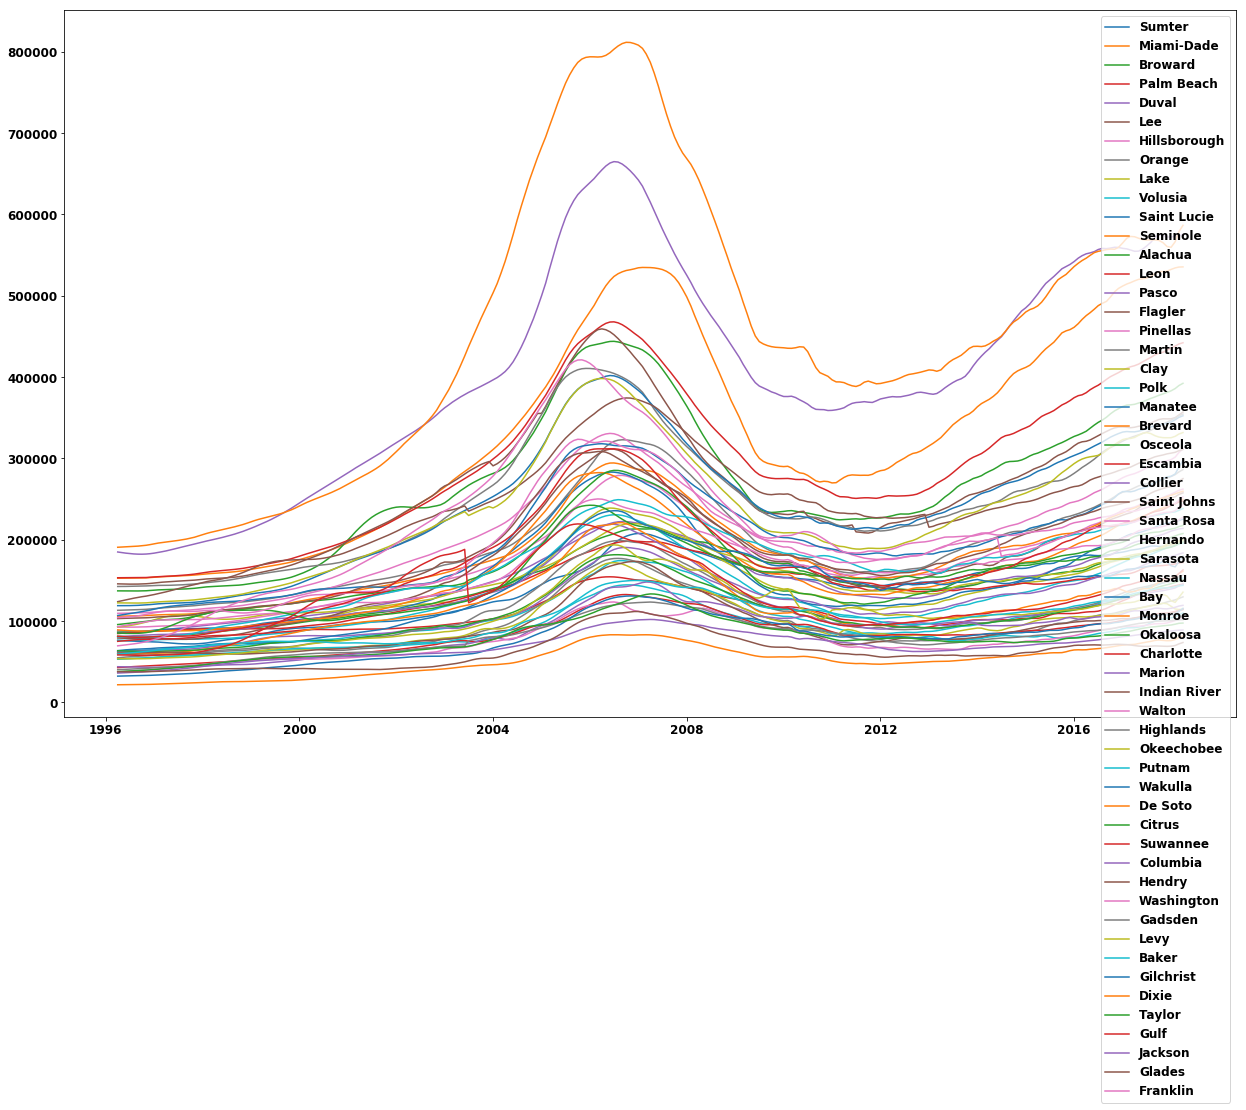

In [13]:
# loop to print out the counties for the state of Florida
plt.figure(figsize=(21,13))
for county in df_fl.CountyName.unique():
    county_data = df_fl.loc[(df_fl.CountyName==county), ['value']].resample('MS').mean()
    plt.plot(county_data, label=county)
plt.legend()
plt.show()

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


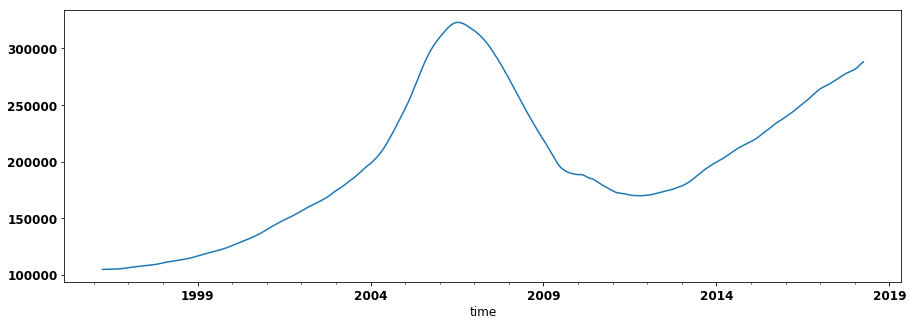

In [14]:
# Florida monthly means ovre the years
florida_monthly = df_fl.groupby(pd.Grouper(freq='MS'))
florida_monthly.value.mean().plot(figsize=(15,5))

No handles with labels found to put in legend.


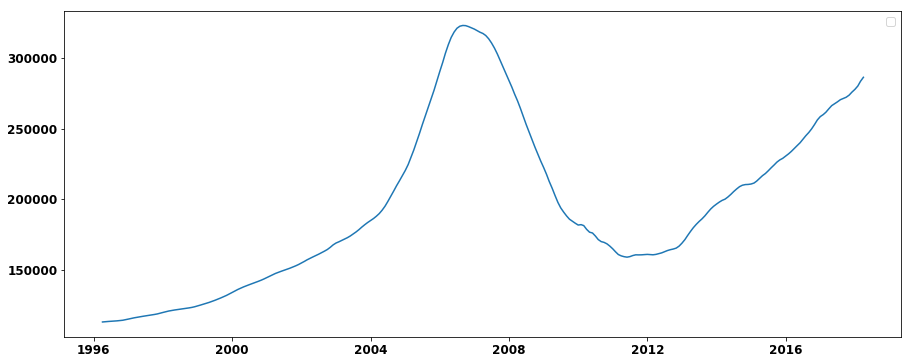

In [76]:
# Separate out the areas that are part of Orange County, Florida BY YEAR 2011
orange_county = df_fl.loc[(df_fl.CountyName=='Orange'), ['value']].resample('MS').mean()
plt.figure(figsize=(15,6))
plt.plot(orange_county)
plt.legend()
plt.show()

# df_fl_2011.loc[(df_fl_2011.CountyName=='Orange'), ['value']].resample('MS').mean()

Overall, Orange county's prices greatly resemble that of the entire state of Florida.

Below, we will take a look at the zip codes that make up Orange county.

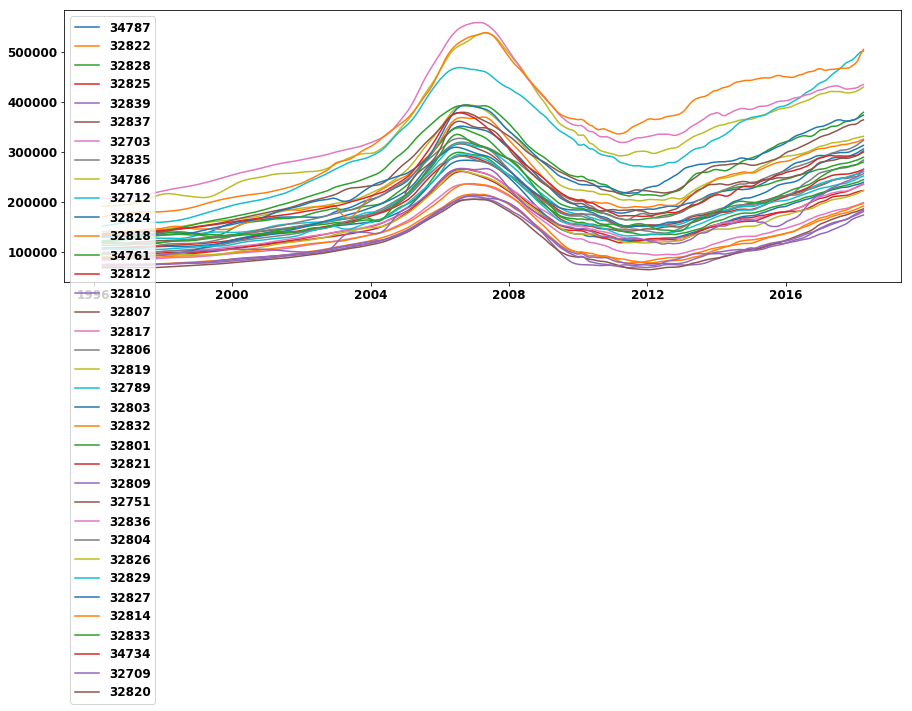

In [77]:
zipcodes = df_fl.loc[(df_fl.CountyName=='Orange')].RegionName.unique()
plt.figure(figsize=(15,5))
for zip_code in zipcodes:
    area = df_fl.loc[(df_fl.RegionName==zip_code), ['value']].resample('MS').mean()
    plt.plot(area, label=zip_code)
    plt.legend(loc='best')
plt.show()

Based on our graph below, there appears to be some seasonality that is occurring within the housing market for orange county as time passes by.

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


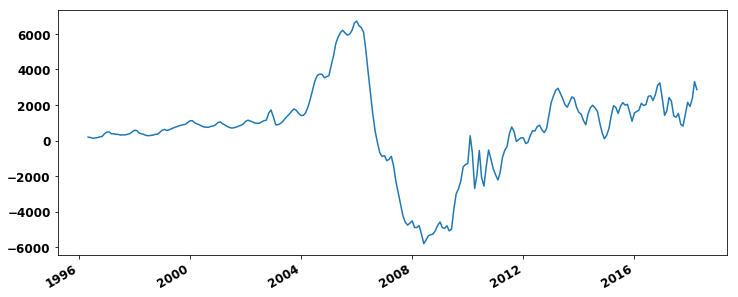

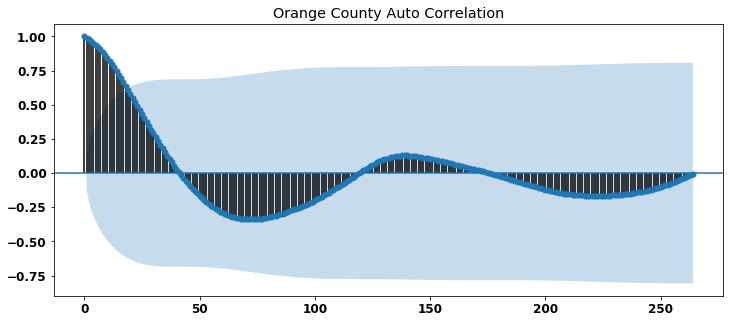

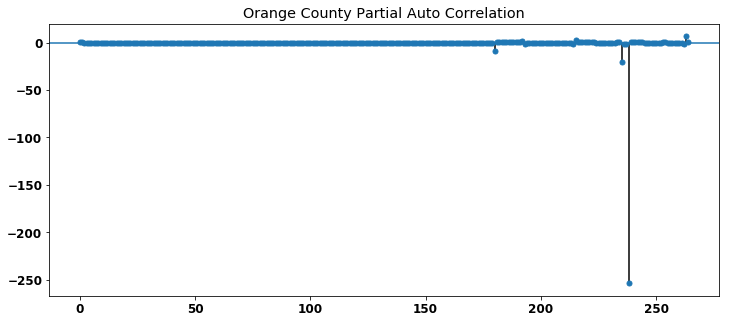

In [83]:
## Looking at difference by year
# Look at the distribution of the diffs and look at the one with the smallest standard deviation
orange_county_diff = orange_county.diff(periods=1)
plt.plot(orange_county_diff)
rcParams['figure.figsize'] = (12, 5)


plt.gcf().autofmt_xdate()
rcParams['figure.figsize'] = (12, 5)

plot_acf(orange_county['value'], title='Orange County Auto Correlation');
plot_pacf(orange_county['value'], title='Orange County Partial Auto Correlation');

Based on what we see in our partial correlation plot, there is a high negative correlation somewhere between 220 - 245 lags.

This high negative appears at lag = 180 months

# Step 4: Reshape from Wide to Long Format

In [21]:
orange_county

,value
time,
1996-04-01,113280.000000
1996-05-01,113471.428571
1996-06-01,113640.000000
1996-07-01,113765.714286
1996-08-01,113905.714286
1996-09-01,114071.428571
1996-10-01,114274.285714
1996-11-01,114500.000000
1996-12-01,114880.000000


# Step 5: ARIMA Modeling

Before getting into the ARIMA modeling, combinations for the model needs to be created.  
Here, the parameters for all combinations of seasons are also added to our values for seasonal & non seasonal arima modeling.

In [22]:
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

## Generate combinations of SARIMA modeling with different seasonalities
# pdqs = []    
# for i in range(0,13):
#     for x in pdq:
#         pdqs.append((x[0], x[1], x[2], i))

pdqs

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [23]:
def model_SARIMA(df=None, order=None, s_order=None, print_table=False, model_fit=False):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df,
                                    order=order,
                                    seasonal_order=s_order,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    output = ARIMA_MODEL.fit()
    if print_table:
        print(output.summary().tables[1])    
    return output

In [24]:
## NEED TO TURN THIS INTO A FUNCTION THAT I CAN PASS
## EACH ZIP CODE INTO AS A DATAFRAME, 
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = model_SARIMA(df=orange_county, order=comb, s_order=combs)
            
#             mod = sm.tsa.statespace.SARIMAX(orange_county,
#                                             order=comb,
#                                             seasonal_order=combs,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             output = mod.fit()
            ans.append([comb, combs, mod.aic, mod.bic])
            print('ARIMA {} x {} : AIC Calculated ={}, BIC Calculated ={}'.format(comb, combs, mod.aic, mod.bic))
        except:
            continue

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


ARIMA (0, 0, 0) x (0, 0, 0, 12) : AIC Calculated =7207.107382668461, BIC Calculated =7210.683331771607
ARIMA (0, 0, 0) x (0, 0, 1, 12) : AIC Calculated =6724.063443220799, BIC Calculated =6731.1223013958215
ARIMA (0, 0, 0) x (0, 1, 0, 12) : AIC Calculated =5901.428529189941, BIC Calculated =5904.957958277453
ARIMA (0, 0, 0) x (0, 1, 1, 12) : AIC Calculated =5633.332729404699, BIC Calculated =5640.294007251384
ARIMA (0, 0, 0) x (1, 0, 0, 12) : AIC Calculated =5917.251571017429, BIC Calculated =5924.318349994885
ARIMA (0, 0, 0) x (1, 0, 1, 12) : AIC Calculated =5834.327772058083, BIC Calculated =5844.916059320617
ARIMA (0, 0, 0) x (1, 1, 0, 12) : AIC Calculated =5501.540902340792, BIC Calculated =5508.510496207773


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (0, 0, 0) x (1, 1, 1, 12) : AIC Calculated =7128.893025464919, BIC Calculated =7139.334942234946
ARIMA (0, 0, 1) x (0, 0, 0, 12) : AIC Calculated =6989.503733298818, BIC Calculated =6996.648041363173
ARIMA (0, 0, 1) x (0, 0, 1, 12) : AIC Calculated =6627.975387565325, BIC Calculated =6638.55174638272
ARIMA (0, 0, 1) x (0, 1, 0, 12) : AIC Calculated =5711.412629116039, BIC Calculated =5718.463534994303
ARIMA (0, 0, 1) x (0, 1, 1, 12) : AIC Calculated =8375.952458686948, BIC Calculated =8386.381849342742
ARIMA (0, 0, 1) x (1, 0, 0, 12) : AIC Calculated =6661.614951153826, BIC Calculated =6672.215119620008
ARIMA (0, 0, 1) x (1, 0, 1, 12) : AIC Calculated =6948.885529952111, BIC Calculated =6962.987341708638
ARIMA (0, 0, 1) x (1, 1, 0, 12) : AIC Calculated =5443.685418603536, BIC Calculated =5454.139809404008
ARIMA (0, 0, 1) x (1, 1, 1, 12) : AIC Calculated =7723.44297633755, BIC Calculated =7737.3488305452765
ARIMA (0, 1, 0) x (0, 0, 0, 12) : AIC Calculated =4870.95348806206, BIC Ca

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 0, 1, 12) : AIC Calculated =4298.358336061002, BIC Calculated =4312.460147817529
ARIMA (1, 0, 1) x (0, 1, 0, 12) : AIC Calculated =4464.3723523930485, BIC Calculated =4474.948711210443


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (0, 1, 1, 12) : AIC Calculated =4056.0541393338867, BIC Calculated =4069.9599935416127
ARIMA (1, 0, 1) x (1, 0, 0, 12) : AIC Calculated =4467.279969042847, BIC Calculated =4481.397685392893


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 0, 1) x (1, 0, 1, 12) : AIC Calculated =4420.7364964624585, BIC Calculated =4438.363761158117
ARIMA (1, 0, 1) x (1, 1, 0, 12) : AIC Calculated =4070.654208747776, BIC Calculated =4084.576764441144
ARIMA (1, 0, 1) x (1, 1, 1, 12) : AIC Calculated =4170.573510470544, BIC Calculated =4187.955828230201
ARIMA (1, 1, 0) x (0, 0, 0, 12) : AIC Calculated =3934.7679626263116, BIC Calculated =3941.9122706906674


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 0) x (0, 0, 1, 12) : AIC Calculated =3770.2250916938538, BIC Calculated =3780.801450511249
ARIMA (1, 1, 0) x (0, 1, 0, 12) : AIC Calculated =3937.238438836846, BIC Calculated =3944.2893447151096
ARIMA (1, 1, 0) x (0, 1, 1, 12) : AIC Calculated =3727.859040381975, BIC Calculated =3738.2884310377694
ARIMA (1, 1, 0) x (1, 0, 0, 12) : AIC Calculated =3768.870728041197, BIC Calculated =3779.4470868585922
ARIMA (1, 1, 0) x (1, 0, 1, 12) : AIC Calculated =3770.4563315763053, BIC Calculated =3784.5581433328325
ARIMA (1, 1, 0) x (1, 1, 0, 12) : AIC Calculated =3720.6962453631513, BIC Calculated =3731.125636018946
ARIMA (1, 1, 0) x (1, 1, 1, 12) : AIC Calculated =3721.07241126629, BIC Calculated =3734.978265474016
ARIMA (1, 1, 1) x (0, 0, 0, 12) : AIC Calculated =3842.432064716081, BIC Calculated =3853.1370982273643


C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA (1, 1, 1) x (0, 0, 1, 12) : AIC Calculated =3660.798872172153, BIC Calculated =3674.884715843602
ARIMA (1, 1, 1) x (0, 1, 0, 12) : AIC Calculated =3887.8483160601504, BIC Calculated =3898.4126988137373
ARIMA (1, 1, 1) x (0, 1, 1, 12) : AIC Calculated =3587.9023864042665, BIC Calculated =3601.7914690989523
ARIMA (1, 1, 1) x (1, 0, 0, 12) : AIC Calculated =3673.843891299348, BIC Calculated =3687.945703055875
ARIMA (1, 1, 1) x (1, 0, 1, 12) : AIC Calculated =3658.42978557664, BIC Calculated =3676.037090165951
ARIMA (1, 1, 1) x (1, 1, 0, 12) : AIC Calculated =3670.7477845399744, BIC Calculated =3684.6536387477004
ARIMA (1, 1, 1) x (1, 1, 1, 12) : AIC Calculated =3548.866446813217, BIC Calculated =3566.2278001815744


After running all of the possible combinations through the seasonal ARIMA model, the results of each combination was stored in a dataframe, so that we can easily search for the optimum model.

In [25]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic', 'bic'])
ans_df

,pdq,pdqs,aic,bic
0,"(0, 0, 0)","(0, 0, 0, 12)",7207.107383,7210.683332
1,"(0, 0, 0)","(0, 0, 1, 12)",6724.063443,6731.122301
2,"(0, 0, 0)","(0, 1, 0, 12)",5901.428529,5904.957958
3,"(0, 0, 0)","(0, 1, 1, 12)",5633.332729,5640.294007
4,"(0, 0, 0)","(1, 0, 0, 12)",5917.251571,5924.318350
5,"(0, 0, 0)","(1, 0, 1, 12)",5834.327772,5844.916059
6,"(0, 0, 0)","(1, 1, 0, 12)",5501.540902,5508.510496
7,"(0, 0, 0)","(1, 1, 1, 12)",7128.893025,7139.334942
8,"(0, 0, 1)","(0, 0, 0, 12)",6989.503733,6996.648041
9,"(0, 0, 1)","(0, 0, 1, 12)",6627.975388,6638.551746


Here we see that the our best model has both the highest `aic`and `bic` scores.

In [26]:
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3548.87
bic           3566.23
Name: 63, dtype: object

In [27]:
ans_df.loc[ans_df['bic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           3548.87
bic           3566.23
Name: 63, dtype: object

Now that we have the results from our SARIMA model, we will now take the results with best AIC and BIC and pass it into our Model to see how ti performed compared to the others

Fitting ARIMA Time Series Model 

In [28]:
def diagnostics_plot(model=None, figsize=(15, 18)):
    model.plot_diagnostics(figsize=figsize)
    plt.show()
    return None

In [29]:
### Get the results of our best parameters for our ARIMA model ###
order = ans_df.loc[ans_df['aic'].idxmin()]['pdq']
s_order = ans_df.loc[ans_df['aic'].idxmin()]['pdqs']
ARIMA_MODEL = model_SARIMA(orange_county, order=order, s_order=s_order, print_table=True)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9723      0.017     56.834      0.000       0.939       1.006
ma.L1          0.6570      0.032     20.572      0.000       0.594       0.720
ar.S.L12       0.0505      0.013      4.010      0.000       0.026       0.075
ma.S.L12      -0.9865      0.251     -3.924      0.000      -1.479      -0.494
sigma2      1.238e+05   2.95e+04      4.201      0.000     6.6e+04    1.82e+05


Now, we are going to take a look where some of the residuals are deviating from the standard deviation and attempt to create a batter model with

### Plottting residuals 

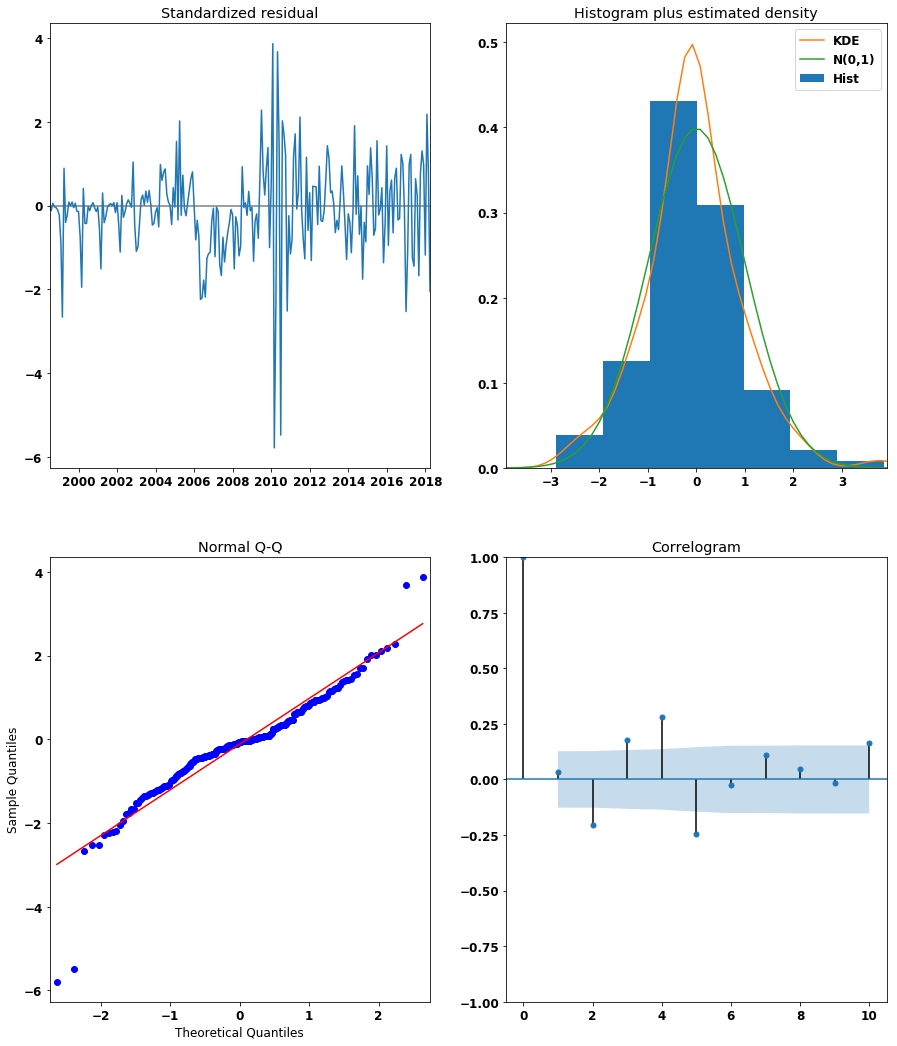

In [30]:
diagnostics_plot(model=ARIMA_MODEL)

Based on the results of the plot diagnostics, we see that our data is not normally distributed. From here, we will continue to further look into our model and attempt to improve the results by removing outliers and the residuals that are causing issues within our model.

## Making predictions using our model parameters 

In [67]:
orange_county.idxmin()

value   1996-04-01
dtype: datetime64[ns]

In [68]:
def one_step_ahead_forecast(df=None, start_date=None, end_date=None, arima_model=None, figsize=(15,6)):
        
    """
        Parameters:
            df:
                Pandas dataframe with the date index and values to graph.
                This dataframe should only be the date indicies and the values associated with the respective indices
            start_date:
                The beginning date for our model to begin its prediction. Enter as a string
                Format:
                    YYYY  or YYYY-MM  or YYYY-MM-DD
            end_date:
                The end date for our prediction model.  Enter as a string
                Format:
                    'YYYY'  or 'YYYY-MM'  or 'YYYY-MM-DD'
            arima_model:
                The arima/sarima model to use for generating predictions 
            
        Return:
            Plots the dynamic prediction data for the model and dataframe passed into the function 
    """
    
    #type case the start and end date as a timestamp object
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    #Setup the confidence interval and the prediction of the model generated
    pred = arima_model.get_prediction(start=start, end=end)
    pred_conf = pred.conf_int()
    
    #Predicted vs real values with confidence intervals
    rcParams['figure.figsize'] = figsize

    #Plot observed values for orange county
    ax = df.plot(label='observed')

    #Plot predicted values
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.5)

    #Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Mean housing prices')
    plt.legend()

    #Plot the prediction and the forecast
    plt.show()
    
    # Get the Real and predicted values
    forecasted = pred.predicted_mean
    truth = orange_county.value

    # Compute the mean square error
    mse = ((forecasted - truth) ** 2).mean()
    print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


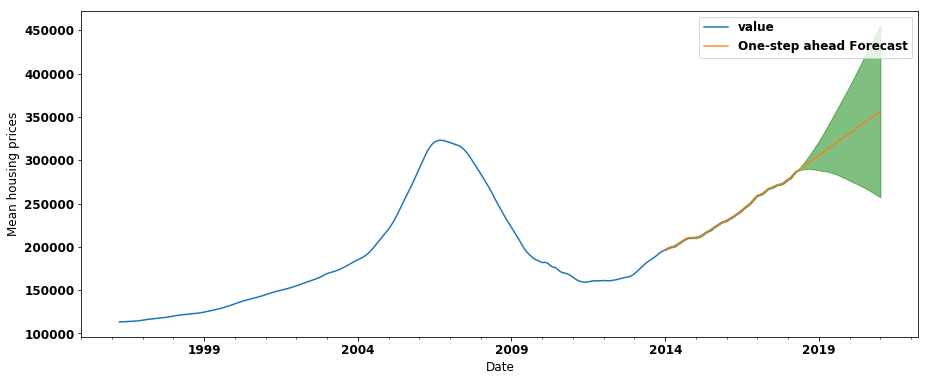

The Mean Squared Error of our forecasts is 143411.5


In [69]:
one_step_ahead_forecast(df=orange_county, start_date='2014', end_date='2021', arima_model=ARIMA_MODEL)

### Dynamic forecasting of the data


In [59]:
def dynamic_prediction(df=None, start_date=None, end_date=None, arima_model=None, figsize=(15,6)):
    """
        df:
            Pandas dataframe with the date index and values to graph
        start_date:
            The beginning date for our model to begin its prediction
        end_date:
            The end date for our prediction model
        arima_model:
            The arima/sarima model to use for generating predictions 
            
        Return:
            Plots the dynamic prediction data for the model and dataframe passed into the function 
    """    
    # Setup the start and end date of the prediction
    pred_start_date = pd.to_datetime(start_date)
    pred_end_date = pd.to_datetime(end_date)

    #Create the dynamic prediction model and confidence intervals
    pred_dynamic = arima_model.get_prediction(start=pred_start_date, 
                                              end=pred_end_date, dynamic=True, full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    
    # Get the Real and predicted values
    forecasted = pred_dynamic.predicted_mean
    truth = df.value

    # Compute the mean square error
    mse = ((forecasted - truth) ** 2).mean()
    print('The Mean Squared Error of our Dynamic forecasts is {}'.format(round(mse, 2)))
    
    # Plot the dynamic forecast with confidence intervals.
    ax = df.plot(label='observed', figsize=figsize)
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)
    ax.fill_betweenx(ax.get_ylim(), pred_start_date, forecasted.index[-1], alpha=.1, zorder=-1)

    #Set labels for the axis
    ax.set_xlabel('Date')
    ax.set_ylabel('Housing Prices')

    #Display graphs
    plt.legend()
    plt.show()


The Mean Squared Error of our Dynamic forecasts is 41664815.38


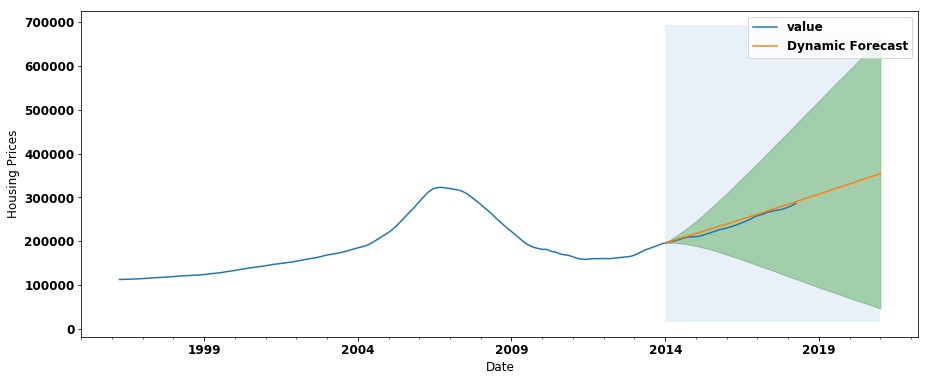

In [60]:
dynamic_prediction(df=orange_county, start_date='2014', end_date='2021', arima_model=ARIMA_MODEL)

In [ ]:
type(pred_dynamic.predicted_mean)

## Findng the best zip code within Orange County

To find the best zip code within the given area, we wil use the following formula to calculate the return of investment:

$$\large R.O.I = \frac{(GFI - CoI)}{CoI}$$

- ROI = Return of Investment
- GFI = Gain from Investment
- CoI = Cost of Investment

Our Cost of Ivestment will be the average of 2017, since we do not have a complete dataset for 2018


To calculate GFI, we will take our cost of investment and subtract it from the average predicted means from 2018 to 2021.

We will then use the formula above to calculate the return of investment for each zip code observed

In [61]:
## Zipcodes of Orange County, Florida
zipcodes

array(['34787', '32822', '32828', '32825', '32839', '32837', '32703',
       '32835', '34786', '32712', '32824', '32818', '34761', '32812',
       '32810', '32807', '32817', '32806', '32819', '32789', '32803',
       '32832', '32801', '32821', '32809', '32751', '32836', '32804',
       '32826', '32829', '32827', '32814', '32833', '34734', '32709',
       '32820'], dtype=object)

In [62]:
ROI_list = []
model_list = []

## Loop to get each zip code and calculate return on ivestment ##
for code in zipcodes:
    zip_df = df_fl.loc[(df_fl.RegionName==code), ['value']].resample('MS').mean()
    zip_model = model_SARIMA(zip_df, order=order, s_order=s_order)

    pred = zip_model.get_prediction(start=pd.to_datetime('2014'), end=pd.to_datetime('2021'))

    ## Define the initial cost of investment as of 2017 ##
    cost_of_investment = zip_df['2017'].value.mean()

    ## Calculate gain from investmnt from 2018 up to 2021 ##
    gain_from_investment = pred.predicted_mean['2018':].mean()

    ## calculate Return of Investment for the observed zip code
    ROI = (gain_from_investment - cost_of_investment)/cost_of_investment
    ROI_list.append(ROI)
    model_list.append(zip_model)

C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Rahkeem\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [63]:
df_results = pd.DataFrame(data=list(zip(zipcodes, ROI_list, model_list)), columns=['zip_code','ROI','model'])

In [64]:
df_results.sort_values(by='ROI', ascending=False).head()

,zip_code,ROI,model
4,32839,0.410655,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
34,32709,0.359474,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
24,32809,0.290911,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
14,32810,0.271944,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
15,32807,0.248570,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [66]:
df_results.sort_values(by='ROI', ascending=False).tail()

,zip_code,ROI,model
30,32827,0.090288,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,34786,0.086312,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
18,32819,0.086224,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,32837,0.075491,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
26,32836,0.044590,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


# Step 6: Interpreting Results

Based on the results of our model, the top 5 zip codes to purchase a house from 2018 -2021 are as follows:
    